In [1]:
from pyelpa import DistributedMatrix
import numpy as np
import h5py
import sys


sys.path.append(".")
dirname = "./bgw_files/k-2x2x2/"

In [2]:
def print_2d_matrix(matrix, decimals=3):
    for row in matrix:
        print(" ".join(f"{val:9.{decimals}f}" for val in row))

In [3]:
# epsinp and sigmain data.
from qtm.interfaces.bgw.epsinp import Epsinp
epsinp = Epsinp.from_epsilon_inp(filename=dirname+'epsilon.inp')

from qtm.interfaces.bgw.sigmainp import Sigmainp
sigmainp = Sigmainp.from_sigma_inp(filename=dirname+'sigma.inp')

In [4]:
from qtm.interfaces.bgw import inp
from qtm.interfaces.bgw.wfn2py import wfn2py

# WFN data
wfndata = wfn2py(dirname+'WFN.h5')
wfnqdata = wfn2py(dirname+'WFNq.h5')

# RHO data
rho = inp.read_rho(dirname+"RHO")

# Vxc data
vxc = inp.read_vxc(dirname+"vxc.dat")

In [5]:
from qtm.gw.core import QPoints
from qtm.gw.epsilon import Epsilon

epsilon = Epsilon.from_data(wfndata=wfndata, wfnqdata=wfnqdata, epsinp=epsinp)

Vcoul calculation for qpts: 100%|██████████| 8/8 [00:00<00:00, 15993.53it/s]


In [6]:
from tqdm import trange
from qtm.gw.core import reorder_2d_matrix_sorted_gvecs, sort_cryst_like_BGW


def calculate_epsilon(numq=None, writing=False):
    epsmats = []
    if numq is None:
        numq = epsilon.qpts.numq

    for i_q in trange(0, numq, desc="Epsilon> q-pt index"):
        # Create map between BGW's sorting order and QTm's sorting order
        gkspc = epsilon.l_gq[i_q]
        
        if i_q == epsilon.qpts.index_q0:
            key = gkspc.g_norm2
        else:
            key = gkspc.gk_norm2

        indices_gspace_sorted = sort_cryst_like_BGW(
            cryst=gkspc.g_cryst, key_array=key
        )

        # Calculate matrix elements
        M = next(epsilon.matrix_elements(i_q=i_q))

        # Calculate polarizability matrix (faster, but not memory-efficient)
        chimat = epsilon.polarizability(M)

        # Calculate polarizability matrix (memory-efficient)
        # chimat = epsilon.polarizability_active(i_q)

        # Calculate epsilon inverse matrix
        epsinv = epsilon.epsilon_inverse(i_q=i_q, polarizability_matrix=chimat, store=True)


        epsinv = reorder_2d_matrix_sorted_gvecs(epsinv, indices_gspace_sorted)
        epsilon.l_epsinv[i_q] = epsinv
        
        # Compare the results with BGW's results
        if i_q == epsilon.qpts.index_q0:
            epsref = epsilon.read_epsmat(dirname + "eps0mat.h5")[0][0, 0]
            if writing:
                epsilon.write_epsmat(
                    filename="test/epsilon/eps0mat_qtm.h5", epsinvmats=[epsinv]
                )
        else:
            epsref = np.array(epsilon.read_epsmat(dirname + "epsmat.h5")[i_q - 1][0, 0])
            epsmats.append(epsinv)

        # Calculate stddev between reference and calculated epsinv matrices
        std_eps = np.std(epsref - epsinv) / np.sqrt(np.prod(list(epsinv.shape)))

        epstol = 1e-16
        if np.abs(std_eps) > epstol:
            print(f"Standard deviation exceeded {epstol} tolerance: {std_eps}, for i_q:{i_q}")

    if writing:
        epsilon.write_epsmat(filename="test/epsilon/epsmat_qtm.h5", epsinvmats=epsmats)


epsinp.no_min_fftgrid = True
epsilon = Epsilon.from_data(wfndata=wfndata, wfnqdata=wfnqdata, epsinp=epsinp)
calculate_epsilon()

Epsilon> q-pt index: 100%|██████████| 8/8 [00:00<00:00, 142.73it/s]

Standard deviation exceeded 1e-16 tolerance: 2.5494915419483335e-15, for i_q:0


In [7]:
from qtm.gw.sigma import Sigma

sigma = Sigma.from_data(
    wfndata=wfndata,
    wfnqdata=wfnqdata,
    sigmainp=sigmainp,
    epsinp=epsinp,
    l_epsmats=epsilon.l_epsinv,
    rho=rho,
    vxc=vxc,
)

Vcoul calculation for qpts: 100%|██████████| 8/8 [00:00<00:00, 17024.06it/s]


vcoul: Vcoul:
        * gspace = <qtm.gspace.gspc.GSpace object at 0x7fcfa3b0e4d0>
        * qpts = <qtm.gw.core.QPoints object at 0x7fcfa39bc510>
        * bare_coulomb_cutoff = 2.0
        * avgcut = 1e-05
        * l_gspace_q = <class 'list'> of length 8
        * vcoul = <class 'list'> of length 8
        * N_SAMPLES = 2500000.0
        * N_SAMPLES_COARSE = 250000.0
        * SEED = 5000
        


Vcoul calculation for qpts: 100%|██████████| 8/8 [00:05<00:00,  1.48it/s]


In [8]:
# Calculate the quasiparticle energies.
sigma.print_condition = False
results_dict = sigma.calculate_static_cohsex()

k_indices = sigma.l_k_indices
num_bands = len(results_dict[k_indices[0]]["Eqp1"])

eqp1_array = np.zeros((len(k_indices), num_bands))
for i, k_idx in enumerate(k_indices):
    eqp1_array[i, :] = results_dict[k_idx]["Eqp1"]

Sigma_CH_Static_Exact: 100%|██████████| 8/8 [00:00<00:00, 104.84it/s]


In [9]:
print("Quasiparticle energies (Eqp1):")
print_2d_matrix(eqp1_array, decimals=6)

Quasiparticle energies (Eqp1):
-6.760997  7.302883  7.303055  7.299997 10.848427 10.848878 10.844457 15.054266
-3.850785 -1.139382  5.640210  5.636517 10.817296 11.579493 11.577671 15.093000
-3.850713 -1.139732  5.640509  5.636530 10.817266 11.579541 11.577562 15.093033
-1.803499 -1.802659  3.380840  3.376889  8.420505  8.421883 19.697087 19.697217
-3.850688 -1.139823  5.640417  5.636727 10.817360 11.579803 11.577952 15.093085
-1.803682 -1.802751  3.380909  3.377123  8.421066  8.421617 19.696966 19.697085
-1.803722 -1.802455  3.380553  3.377231  8.420957  8.421618 19.697046 19.697046
-3.851600 -1.141514  5.639899  5.640203 10.816857 11.582074 11.581970 15.093132


In [10]:
from kernel import KernelMtxEl

q0 = [0.001, 0.001, 0.001]
l_qpts = np.array(epsinp.qpts)
l_qpts[0] *= 0
qpts = QPoints.from_cryst(wfndata.kpts.recilat, None, *l_qpts)

kernelclass = KernelMtxEl.from_BGW(
    wfndata=wfndata,
    epsinp=epsinp,
    sigmainp=sigmainp,
    q0=q0,
    l_epsmats=epsilon.l_epsinv,
    parallel=True,
)

In [11]:
data = kernelclass.kernel_mtxel()
exc = data["exc"]
head = data["head"]
body = data["body"]
wings = data["wings"]

In [12]:
numq = kernelclass.qpts.numq
numk = kernelclass.kpts.numk

In [13]:
from intkernel import InterpMtxEl

InterpClass = InterpMtxEl.from_BGW(
    wfn_finedata=wfndata,
    wfn_coarsedata=wfndata,
    epsinp=epsinp,
    sigmainp=sigmainp,
    kernel=kernelclass,
)

In [14]:
energyval = InterpClass.interp_energy(eqp1_array, 'val')
energycon = InterpClass.interp_energy(eqp1_array, 'con')

In [15]:
fine_kernel = InterpClass.interp_kernel(head, wings, body, exc, sigma.vcoul)

In [16]:
HBSE = InterpClass.construct_HBSE(fine_kernel, energyval, energycon)
HGW = InterpClass.construct_HBSE(0, energyval, energycon)

In [17]:
from diag import diag_elpa

eigval_elpa, eigvec_elpa = diag_elpa(HBSE)
eigval_numpy, eigvec_numpy = np.linalg.eigh(HBSE)

In [18]:
eigval_GW_elpa, eigvec_GW_elpa = diag_elpa(HGW)
eigval_GW_numpy, eigvec_GW_numpy = np.linalg.eigh(HGW)

In [23]:
from abs import Absorption

AbsClassBSE = Absorption.from_BGW(
    wfndata=wfndata,
    wfnqdata=wfnqdata,
    epsinp=epsinp,
    sigmainp=sigmainp,
    eigvals=eigval_elpa,
    eigvecs=eigvec_elpa,
    polarization=np.array([1, 1, 1]),
)

In [24]:
AbsClassGW = Absorption.from_BGW(
    wfndata=wfndata,
    wfnqdata=wfnqdata,
    epsinp=epsinp,
    sigmainp=sigmainp,
    eigvals=eigval_GW_elpa,
    eigvecs=eigvec_GW_elpa,
    polarization=np.array([1, 1, 1]),
)


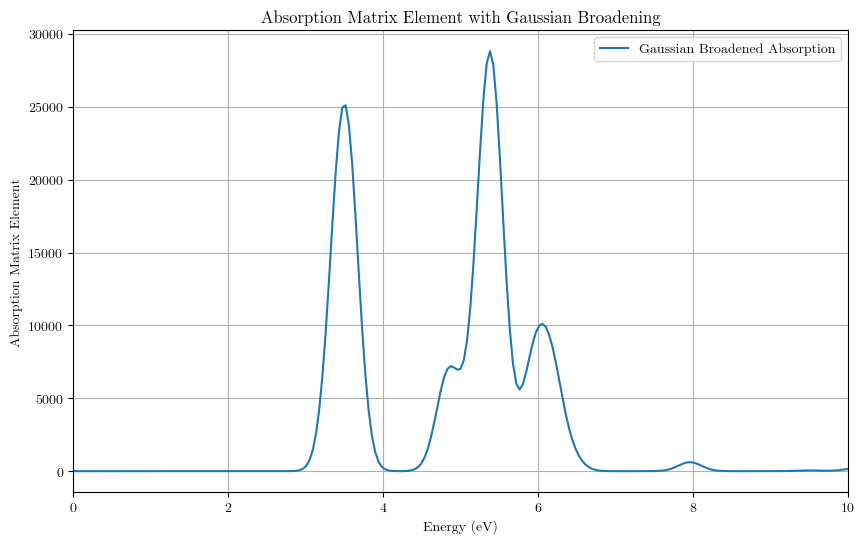

In [29]:
AbsClassBSE.plot_abs_broadened(sigma = 0.15)